In [1]:
%load_ext autoreload
%autoreload complete

from os.path import join
import pickle
from datetime import datetime
import pandas as pd
import numpy as np
from dotenv import dotenv_values
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from pyarrow import parquet as pq
import seaborn as sns
from sklearn.preprocessing import scale

import gsvd

sns.set_theme(style="darkgrid")

cfg = dotenv_values()

dat_dir = cfg['DAT_DIR']

alpha = 1

typing_mats_file = join(dat_dir, 'BiAffect_Alex', 'typing_mat_dict.pkl')
svd_mats_file = join(dat_dir, 'BiAffect_Alex', f"svd_mats_alpha{alpha}_tail.pkl")

/home/preclineu/lorkno/Documents/Code/graph-svd/gsvd.py:22: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
dat_kp: pd.DataFrame = pq.read_table(join(dat_dir, 'BiAffect_Alex', 'dat_kp_alex.parquet')).to_pandas()

dat_kp = dat_kp.loc[dat_kp['phoneType'] == 'iPhone 15'].copy()

# Pandas has trouble computing the min of a date, so convert back to datetime
dat_kp['date'] = pd.to_datetime(dat_kp['keypress_timestamp'].dt.date)
dat_kp['hour'] = dat_kp['keypress_timestamp'].dt.hour
dat_kp['subject'] = 'alex'

dat_kp

In [ ]:
dat_ses: pd.DataFrame = pq.read_table(join(dat_dir, 'BiAffect_Alex', 'dat_ses_alex.parquet')).to_pandas()

dat_ses = dat_ses.loc[dat_ses['phoneType'] == 'iPhone 15'].copy()

dat_ses['date'] = pd.to_datetime(dat_ses['date'])
dat_ses['hour'] = dat_ses['hour'].astype(int)
dat_ses['subject'] = 'alex'

dat_ses

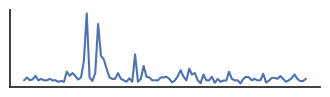

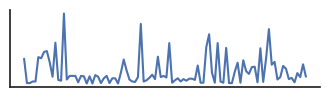

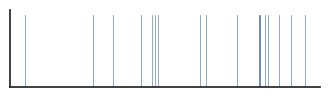

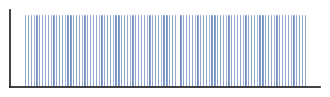

In [24]:
modalities = ['medianIKD', 'totalKeyPresses', 'active', 'upright']
geoms = ['line', 'line', 'bar', 'bar']

for modality, geom in zip(modalities, geoms):
    plt.close()

    fig = plt.figure(figsize=(4, 1))
    
    n = 100
    
    # x = dat_kp['keypress_timestamp']
    x = np.arange(n)
    y = dat_ses[modality][:n]
    
    with sns.axes_style("white"):
        if geom == 'line':
            plt.plot(x, y)
        else:
            plt.bar(x, y)
            
        sns.despine()
        plt.xticks([])
        plt.yticks([])

        plt.savefig(join('images', 'alex', f"data_{modality}_alex_raw.pdf"),
                    bbox_inches='tight', pad_inches=0)
        plt.show()

In [ ]:
typing_matrices, dates = gsvd.get_typing_matrices(dat_kp, dat_ses)

<Axes: xlabel='hour', ylabel='dayNumber'>

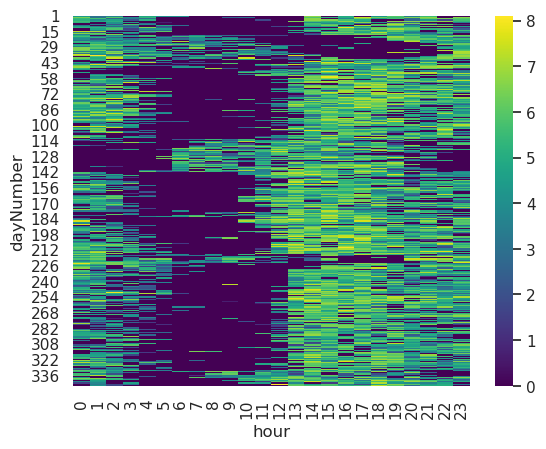

In [5]:
typing_mats = typing_matrices['alex']

sns.heatmap(np.log1p(typing_mats['n_presses']), cmap='viridis')

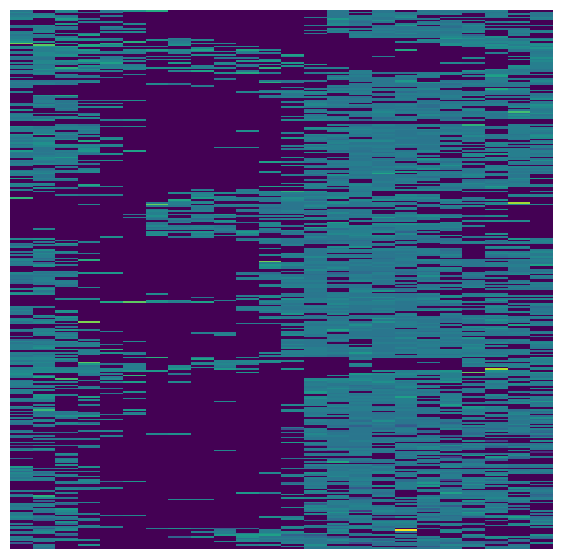

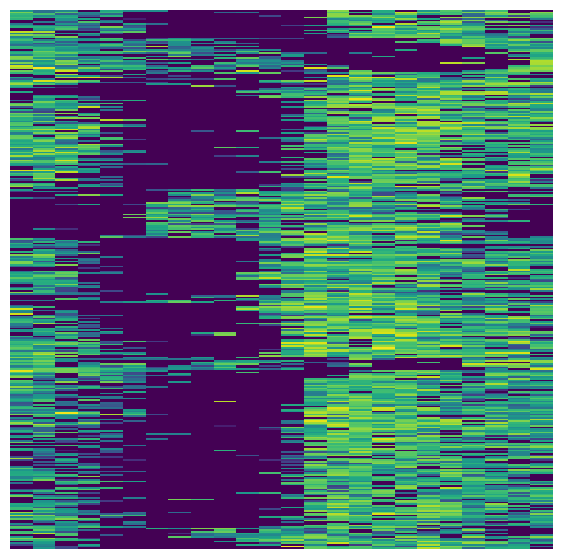

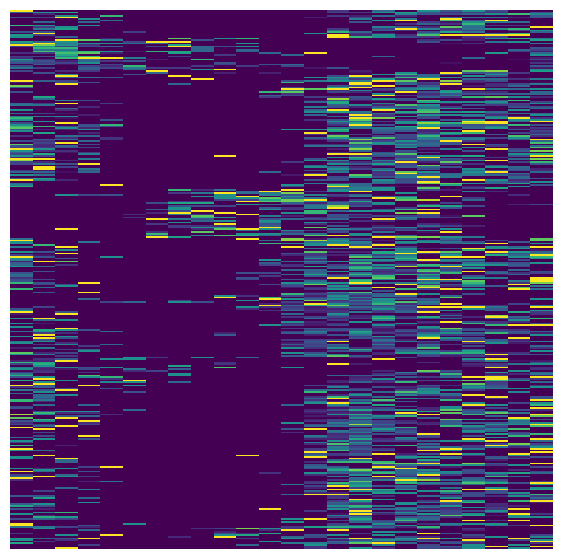

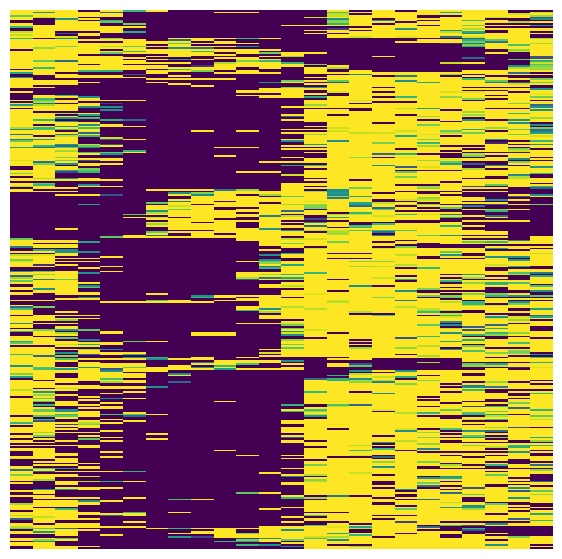

In [9]:
for modality, mat in typing_mats.items():
    if modality == 'n_presses':
        mat = np.log1p(mat)

    mat = mat.values
    
    # Scale to unit variance
    mat = mat / np.std(mat)

    plt.close()

    plt.figure(figsize=(7, 7))
    plt.imshow(mat, 
               aspect='auto', cmap='viridis', interpolation='none')
    plt.axis('off')

    plt.savefig(join('images', 'alex', f"data_{modality}_alex_scaled.pdf"),
                bbox_inches='tight', pad_inches=0)
    
    plt.show()

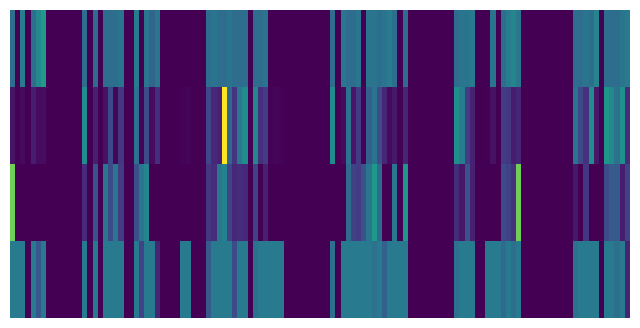

In [30]:
flattened = [df.values.flatten() for df in typing_mats.values()]
stacked = np.vstack(flattened)
scaled = scale(stacked.T, with_mean=False).T

plt.close()

plt.figure(figsize=(8, 4))

plt.imshow(scaled[:, :5*24], cmap='viridis', aspect='auto')

plt.axis('off')

plt.savefig(join('images', 'alex', f"data_stacked_alex.pdf"),
            bbox_inches='tight', pad_inches=0)

plt.show()

plt.show()

# Saving/Loading typing mats

In [11]:
# Saving
typing_mat_dict = {
    "typing_matrices": typing_matrices,
    "dates": dates
}

with open(typing_mats_file, 'wb') as f:
    pickle.dump(typing_mat_dict, f)

In [2]:
# Loading
with open(typing_mats_file, 'rb') as f:
    typing_mat_dict = pickle.load(f)

typing_matrices: dict[str, dict[str, pd.DataFrame]] = typing_mat_dict["typing_matrices"]
typing_mats = typing_matrices['alex']
dates: pd.DataFrame = typing_mat_dict["dates"]

# Calculating GSVD

In [6]:
svd_mats, split_indices = gsvd.calculate_svd(
    typing_matrices, alpha=alpha, train_ratio=0.05, train_tail=True)

  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# Saving
with open(svd_mats_file, 'wb') as f:
    pickle.dump(svd_mats, f)

In [9]:
# Loading
with open(svd_mats_file, 'rb') as f:
    svd_mats: dict[str, dict[str, np.ndarray]] = pickle.load(f)

<Axes: >

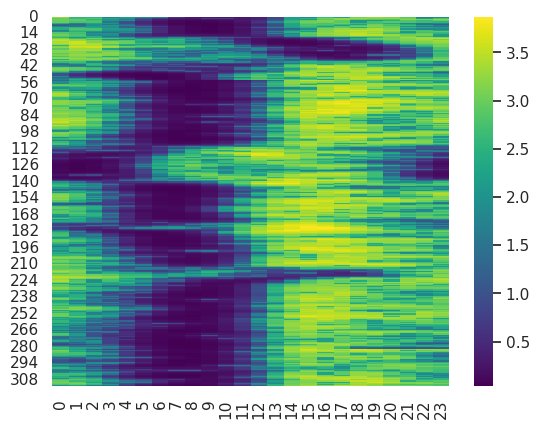

In [4]:
svd_mats = svd_mats['alex']

plt.close()

sns.heatmap(svd_mats['test'], cmap='viridis')

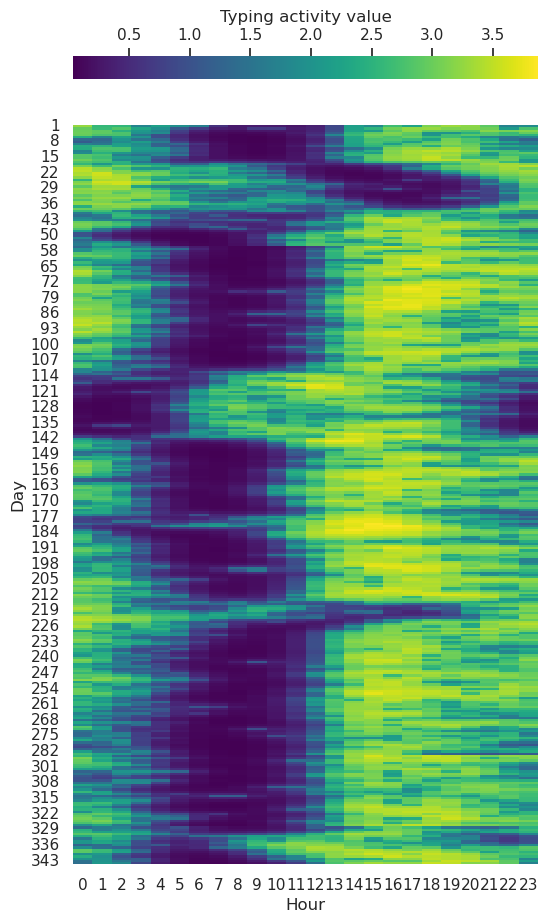

In [5]:
# Training set is in the tail this time
svd_mat = np.vstack((svd_mats['test'], svd_mats['train']))

ikd_df = typing_mats['IKD']
svd_df = pd.DataFrame(svd_mat, index=ikd_df.index)

plt.close()

plt.figure(figsize=(6, 12))
sns.heatmap(svd_df, cmap='viridis', 
            cbar_kws={'location': 'top', 'label': 'Typing activity value'})

# plt.scatter(24, 29, c="red")

plt.xticks(rotation=0)

plt.xlabel('Hour')
plt.ylabel('Day')

# plt.savefig(join('images', 'alex', f"svd_alex.pdf"),
#             bbox_inches='tight')

plt.show()

<Axes: ylabel='Count'>

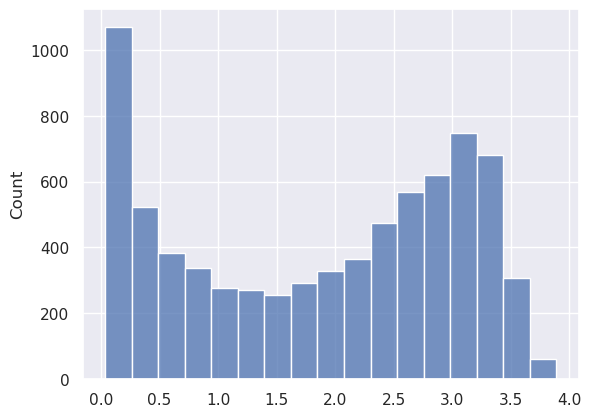

In [26]:
sns.histplot(svd_mats['test'].flatten())

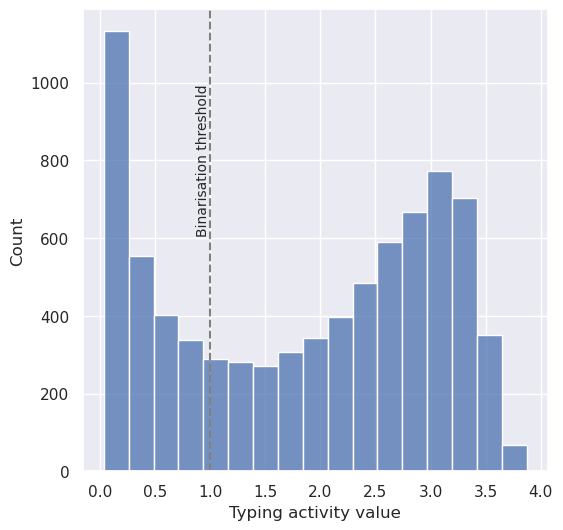

In [29]:
plt.close()

threshold = 1

plt.figure(figsize=(6, 6))

sns.histplot(svd_mat.flatten())

plt.annotate("Binarisation threshold", 
           xy=(threshold, 800), rotation='vertical', 
           ha='right', va='center', fontsize='small')
plt.axvline(x=threshold, color='grey', linestyle='dashed')

plt.xlabel("Typing activity value")

# plt.savefig(join('images', 'alex', f"hist_alex.pdf"),
#             bbox_inches='tight')

plt.show()

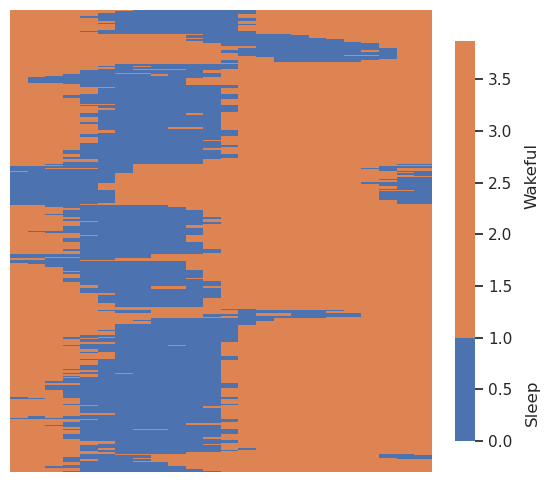

In [12]:
plt.close()

plt.figure(figsize=(6, 6))

max_val = np.max(svd_mat)
binary_mat = (svd_mat > threshold) * max_val
sns.heatmap(binary_mat, cmap=sns.color_palette(n_colors=2), vmin=0, vmax=max_val,
            cbar_kws={'fraction': 0.043}, center=threshold)

plt.xlabel('Hour')
plt.ylabel('Day')
plt.tick_params(axis='x', labelrotation=0)

a = plt.gca()
plt.text(1.22, 0.64, 'Wakeful', transform=a.transAxes, 
       rotation=90, va='center')
plt.text(1.22, 0.15, 'Sleep', transform=a.transAxes, 
       rotation=90, va='center')

plt.axis('off')

plt.savefig(join('images', 'alex', f"binarized_svd_alex.pdf"),
            bbox_inches='tight')

plt.show()

In [ ]:
plt.close()

fig = plt.figure(figsize=(2, 6))

sleep_mat = svd_mat < threshold
sleep_ests = np.sum(sleep_mat, axis=1)

with sns.axes_style("white"):
    plt.plot(np.flip(sleep_ests), np.arange(len(sleep_ests)))
    plt.xlabel('Hours slept')
    plt.yticks([])
    sns.despine(trim=True)

plt.savefig(join('images', 'alex', f"hours_slept_alex.pdf"),
            bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

In [ ]:
n_train = svd_mats['train'].shape[0]
n_test = svd_mats['test'].shape[0]

# Training was done by tail of data set
labels = ['test'] * n_test + ['train'] * n_train
svd_mat = np.vstack((svd_mats['test'], svd_mats['train']))

# Convert to DataFrame
ikd_index = typing_matrices['alex']['IKD'].index
svd_df = pd.DataFrame(svd_mat, index=ikd_index)

svd_df['label'] = labels

svd_df

In [8]:
svd_date_df = dates.set_index(['dayNumber']) \
    .join(svd_df, how='right') \
    .set_index(['date']) \
    .drop(columns=['subject']) \
    .reset_index()

svd_df_long = pd.melt(svd_date_df, id_vars=['date', 'label'], var_name='hour') \
    .sort_values(['date', 'hour']) \
    .reset_index(drop=True)

svd_df_long['date'] = svd_df_long['date'].dt.date

svd_df_long

,date,label,hour,value
0,2023-12-11,test,0,3.270567
1,2023-12-11,test,1,2.583855
2,2023-12-11,test,2,2.563488
3,2023-12-11,test,3,1.767363
4,2023-12-11,test,4,2.207104
...,...,...,...,...
7939,2024-11-18,train,19,3.504055
7940,2024-11-18,train,20,3.157552
7941,2024-11-18,train,21,3.189268
7942,2024-11-18,train,22,2.914041


In [15]:
svd_df_long.to_parquet(join(dat_dir, 'BiAffect_Alex', 'svd_long_tail.parquet'))

# Polar plot

In [6]:
def plot_polar(theta, r, a):
    tick_positions = np.linspace(0, 2, 8, endpoint=False) * np.pi
    tick_labels = ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']

    cmap = mpl.colormaps['viridis']
    cols = cmap([val / np.max(svd_mat) for val in r])
    
    # a.plot(theta, r)
    a.bar(theta, r, color=cols, width=0.2)
    # a.scatter(theta, r, c=r, cmap='viridis')
    # ax.set_rmax(2)
    a.set_rticks([1, 2, 3])  # Less radial ticks
    a.set_rlabel_position(-225)  # Move radial labels away from plotted bars
    a.set_xticks(tick_positions, tick_labels, size='small')
    a.grid(True)

def draw_vector(theta, r, ax):
    ax.annotate(
        '',
        xy=(theta, r),
        xytext=(0, 0), 
        arrowprops=dict(facecolor='black', shrink=0),
        horizontalalignment='right'
    )

def set_concise_dates(a, show_offset=True):
    locator = mdates.AutoDateLocator(interval_multiples=False)
    formatter = mdates.ConciseDateFormatter(locator, show_offset=show_offset)
    a.xaxis.set_major_locator(locator)
    a.xaxis.set_major_formatter(formatter)
    for label in a.get_xticklabels():
        label.set_rotation(40)
        label.set_horizontalalignment('right')

In [19]:
theta = np.linspace(0, 2, svd_mat.shape[1], endpoint=False) * np.pi

# svd_mat: (N, 24)
# theta: (24,)
# x_means and y_means: (N,)
x_means = np.sum(svd_mat * np.cos(theta), axis=1) / len(theta)
y_means = np.sum(svd_mat * np.sin(theta), axis=1) / len(theta)

mean_angles = np.arctan2(y_means, x_means)
mean_rs = np.sqrt(np.square(x_means) + np.square(y_means))

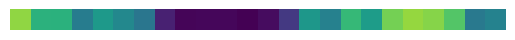

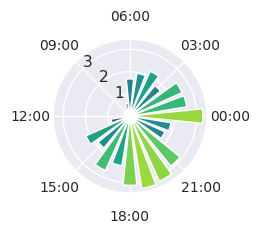

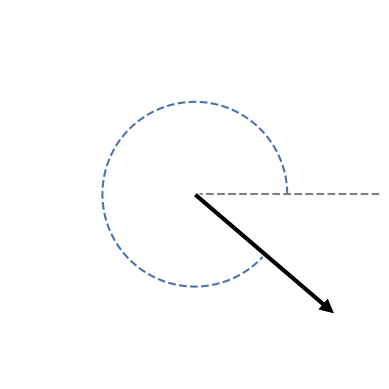

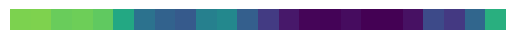

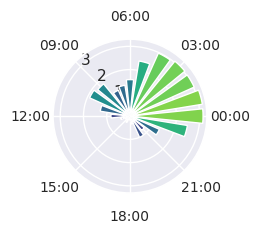

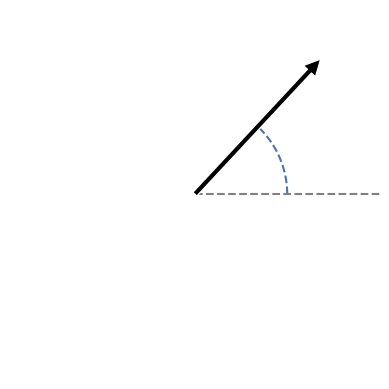

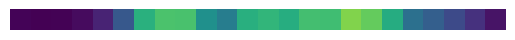

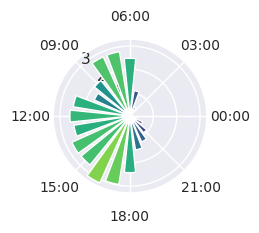

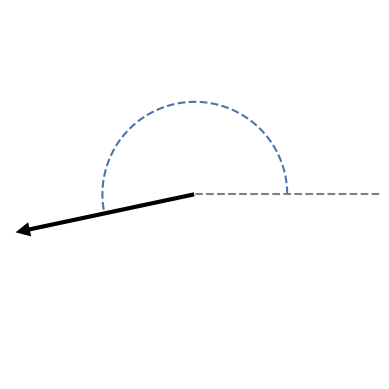

In [45]:
theta = np.linspace(0, 2, svd_mat.shape[1], endpoint=False) * np.pi

indices = [0, 29, 128]

for idx in indices:

    # Matrix row plot
    plt.close()
    
    r = svd_mat[idx, :]
    plt.imshow(np.expand_dims(r, 0), vmax=svd_mat.max(), cmap='viridis')
    plt.grid(False)
    plt.axis('off')

    plt.savefig(join('images', 'alex', f"matrix_row_{idx}.pdf"),
                bbox_inches='tight', transparent=True)
    plt.show()
    
    # Polar bar plot
    plt.close()
    
    fig, ax = plt.subplots(ncols = 1, figsize=(2, 2), subplot_kw={'projection': 'polar'})
    plot_polar(theta, r, ax)

    plt.savefig(join('images', 'alex', f"polar_bars_{idx}.pdf"),
                bbox_inches='tight', transparent=True)
    plt.show()

    # Arrow plot
    plt.close()
    
    fig, ax = plt.subplots(ncols = 1, subplot_kw={'projection': 'polar'})
    draw_vector(mean_angles[idx], mean_rs[idx], ax)

    ang = mean_angles[idx]
    th = 2*np.pi + ang if ang < 0 else ang
    diff_thetas = np.arange(0, th, 0.01)
    ax.plot(diff_thetas, np.repeat(mean_rs[idx] * 0.5, len(diff_thetas)), 
            linestyle='--')
    ax.plot([0, 0], [0, mean_rs[idx]], linestyle='--', color='grey')
    ax.set_rlim(0, mean_rs[idx])
    
    plt.axis('off')

    plt.savefig(join('images', 'alex', f"polar_arrow_{idx}.pdf"),
                bbox_inches='tight', transparent=True)
    plt.show()

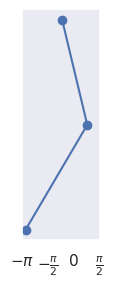

In [56]:
plt.close()

plt.figure(figsize=(1, 3))

x = mean_angles[indices[::-1]]
y = np.arange(len(indices))
plt.plot(x, y)
plt.scatter(x, y)
plt.xticks(np.linspace(-np.pi, np.pi/2, 4), [r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$'])
plt.yticks([])
plt.grid(False)

plt.savefig(join('images', 'alex', 'theta_0_29_128.pdf'),
            bbox_inches='tight', transparent=True)

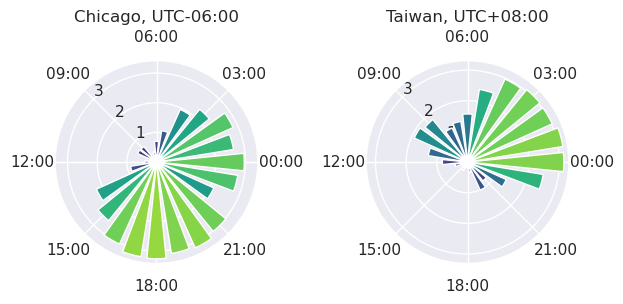

In [46]:
%matplotlib inline

plt.close()

theta = np.linspace(0, 2, svd_mat.shape[1], endpoint=False) * np.pi

fig, ax = plt.subplots(ncols = 2, subplot_kw={'projection': 'polar'})

# Chicago day, UTC-06:00
r = svd_mat[1, :]

a = ax[0]

plot_polar(theta, r, a)

a.set_title("Chicago, UTC-06:00")

# Taiwan day, UTC+08:00
r = svd_mat[29, :]

a = ax[1]

plot_polar(theta, r, a)

a.set_title("Taiwan, UTC+08:00")

fig.tight_layout()

plt.show()

# fig.savefig(join('images', 'alex', 'polar_alex.pdf'))

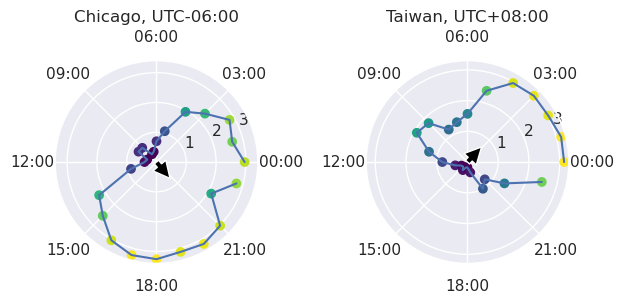

In [10]:
plt.close()

fig, ax = plt.subplots(ncols=2, subplot_kw={'projection': 'polar'})

theta = np.linspace(0, 2, svd_mat.shape[1], endpoint=False) * np.pi

# Chicago day, UTC-06:00
i = 1
r = svd_mat[i, :]

a = ax[0]

draw_vector(mean_angles[i], mean_rs[i], a)

plot_polar(theta, r, a)
a.set_title("Chicago, UTC-06:00")

# Taiwan day, UTC+08:00
i = 29
r = svd_mat[i, :]

a = ax[1]

draw_vector(mean_angles[i], mean_rs[i], a)

plot_polar(theta, r, a)
a.set_title("Taiwan, UTC+08:00")

fig.tight_layout()

plt.show()

fig.savefig(join('images', 'alex', 'polar_mean_alex.pdf'))

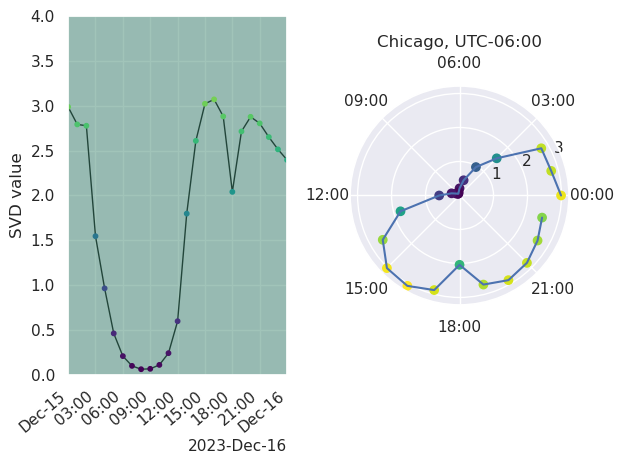

In [48]:
dates_svd = pd.to_datetime(svd_df_long['date'])
time_svd = dates_svd + pd.to_timedelta(svd_df_long['hour'], unit='hour')

min_dt = datetime(2023, 12, 15)
max_dt = datetime(2023, 12, 16)

fig = plt.figure()

a = fig.add_subplot(121)

svd_vals = svd_mat.flatten()
a.plot(time_svd, svd_vals, c='black', linewidth=1, zorder=1)
a.scatter(time_svd, svd_vals, c=svd_vals, cmap='viridis', s=10, zorder=2)

rect = patches.Rectangle(
    (min_dt, -1), max_dt - min_dt, 5, 
    linewidth=0, 
    facecolor='#458B74',
    alpha=0.5)
a.add_patch(rect)

a.set_xlim(min_dt, max_dt)
a.set_ylim(0, 4)
a.set_ylabel("SVD value")

# Create a slightly prettier x-axis
set_concise_dates(a)

# Chicago day, UTC-06:00
r = svd_mat[4, :]

a = fig.add_subplot(122, projection='polar')

plot_polar(theta, r, a)

a.set_title("Chicago, UTC-06:00")

fig.tight_layout()

fig.savefig(join('images', 'alex', 'line_polar_alex.pdf'))

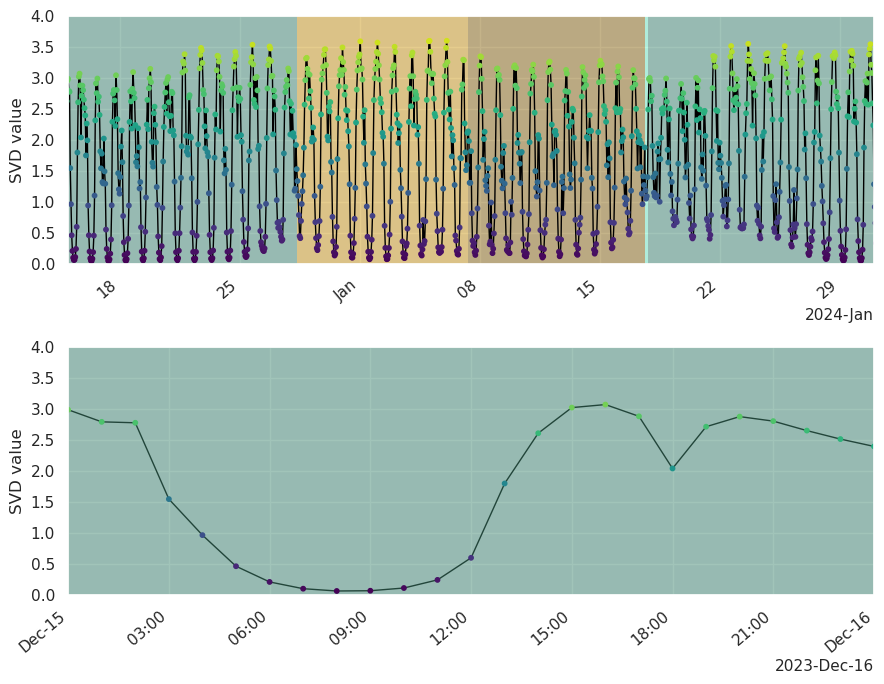

In [51]:
plt.close()

fig, ax = plt.subplots(nrows=2, figsize=(9, 7))

# Taiwan trip
min_dt = datetime(2023, 12, 15)
max_dt = datetime(2024, 1, 31)

a = ax[0]

colors = {
    'UTC-06:00': '#458B74', # aquamarine4
    'UTC+09:00': '#CD9B1D', # goldenrod3
    'UTC+08:00': '#8B6914', # goldenrod4
    'UTC-08:00': '#76EEC6', # aquamarine2
}

for i in range(5):
    trans = dat_transition.iloc[i]
    start, end = trans['session_timestamp'], trans['next_timestamp']
    rect = patches.Rectangle(
        (start, -1), end - start, 5, 
        linewidth=0, 
        facecolor=colors[trans['timezone']],
        alpha=0.5)
    a.add_patch(rect)

svd_vals = svd_mat.flatten()
a.plot(time_svd, svd_vals, c='black', linewidth=1, zorder=1)
a.scatter(time_svd, svd_vals, c=svd_vals, cmap='viridis', s=10, zorder=2)
a.set_xlim(min_dt, max_dt)
a.set_ylim(0, 4)
a.set_ylabel("SVD value")

set_concise_dates(a)

# Zoomed
min_dt = datetime(2023, 12, 15)
max_dt = datetime(2023, 12, 16)

a = ax[1]

a.plot(time_svd, svd_vals, c='black', linewidth=1, zorder=1)
a.scatter(time_svd, svd_vals, c=svd_vals, cmap='viridis', s=10, zorder=2)

rect = patches.Rectangle(
    (min_dt, -1), max_dt - min_dt, 5, 
    linewidth=0, 
    facecolor='#458B74',
    alpha=0.5)
a.add_patch(rect)

a.set_xlim(min_dt, max_dt)
a.set_ylim(0, 4)
a.set_ylabel("SVD value")

set_concise_dates(a)

fig.tight_layout()

fig.savefig(join('images', 'alex', 'line_zoom_alex.pdf'))

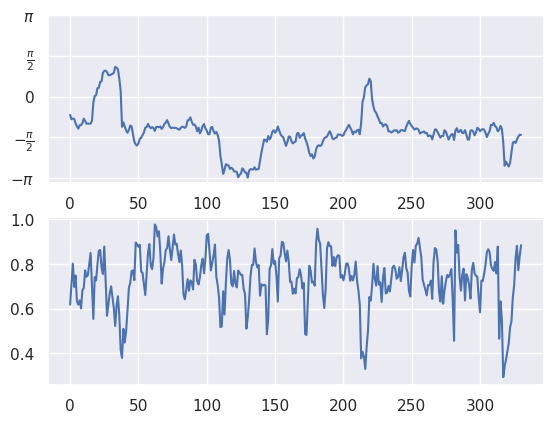

In [36]:
fig, ax = plt.subplots(nrows=2)

a = ax[0]
a.plot(mean_angles)
a.set_yticks(np.linspace(-np.pi, np.pi, 5), [r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$', r'$\pi$'])

a = ax[1]
a.plot(mean_rs)

plt.show()

In [ ]:
# Calculated in R
dat_transition: pd.DataFrame = pq.read_table(join(dat_dir, 'BiAffect_Alex', 'dat_transition_alex.parquet')) \
    .to_pandas()

dat_transition

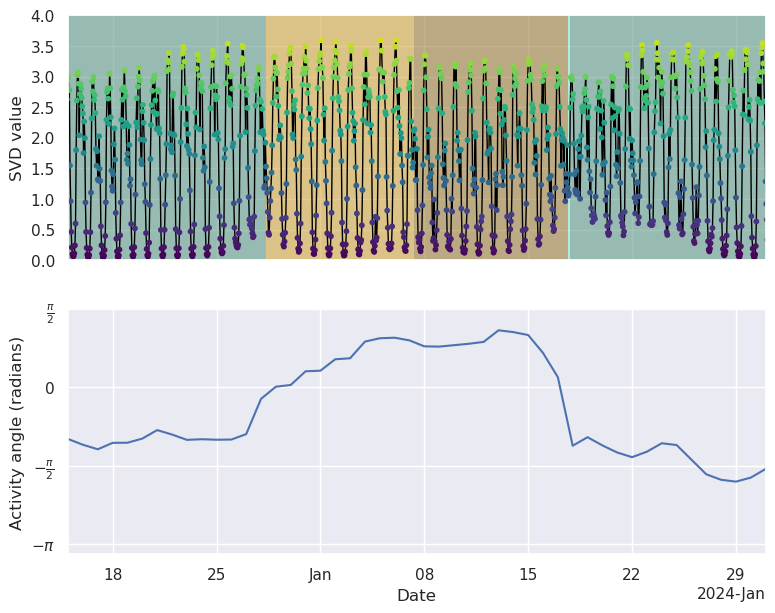

In [30]:
plt.close()

min_dt = datetime(2023, 12, 15)
max_dt = datetime(2024, 1, 31)

dates_svd = pd.to_datetime(svd_df_long['date'])
time_svd = dates_svd + pd.to_timedelta(svd_df_long['hour'], unit='hour')

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(9, 7))

a = ax[0]

colors = {
    'UTC-06:00': '#458B74', # aquamarine4
    'UTC+09:00': '#CD9B1D', # goldenrod3
    'UTC+08:00': '#8B6914', # goldenrod4
    'UTC-08:00': '#76EEC6', # aquamarine2
}

for i in range(5):
    trans = dat_transition.iloc[i]
    start, end = trans['session_timestamp'], trans['next_timestamp']
    rect = patches.Rectangle(
        (start, -1), end - start, 5, 
        linewidth=0, 
        facecolor=colors[trans['timezone']],
        alpha=0.5)
    a.add_patch(rect)

svd_vals = svd_mat.flatten()
a.plot(time_svd, svd_vals, c='black', linewidth=1, zorder=1)
a.scatter(time_svd, svd_vals, c=svd_vals, cmap='viridis', s=10, zorder=2)
a.set_ylim(0, 4)
a.set_ylabel("SVD value")

# Mean angles
a = ax[1]

a.plot(dates_svd[0::24], mean_angles)
a.set_ylabel("Activity angle (radians)")
a.set_yticks(np.linspace(-np.pi, np.pi/2, 4), [r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$'])

# Create a slightly prettier x-axis
locator = mdates.AutoDateLocator(interval_multiples=False)
formatter = mdates.ConciseDateFormatter(locator)
a.xaxis.set_major_locator(locator)
a.xaxis.set_major_formatter(formatter)

plt.xlabel('Date')
plt.xlim(min_dt, max_dt)

plt.show()

fig.savefig(join('images', 'alex', 'phase_shift_alex.pdf'))

## Combine plots

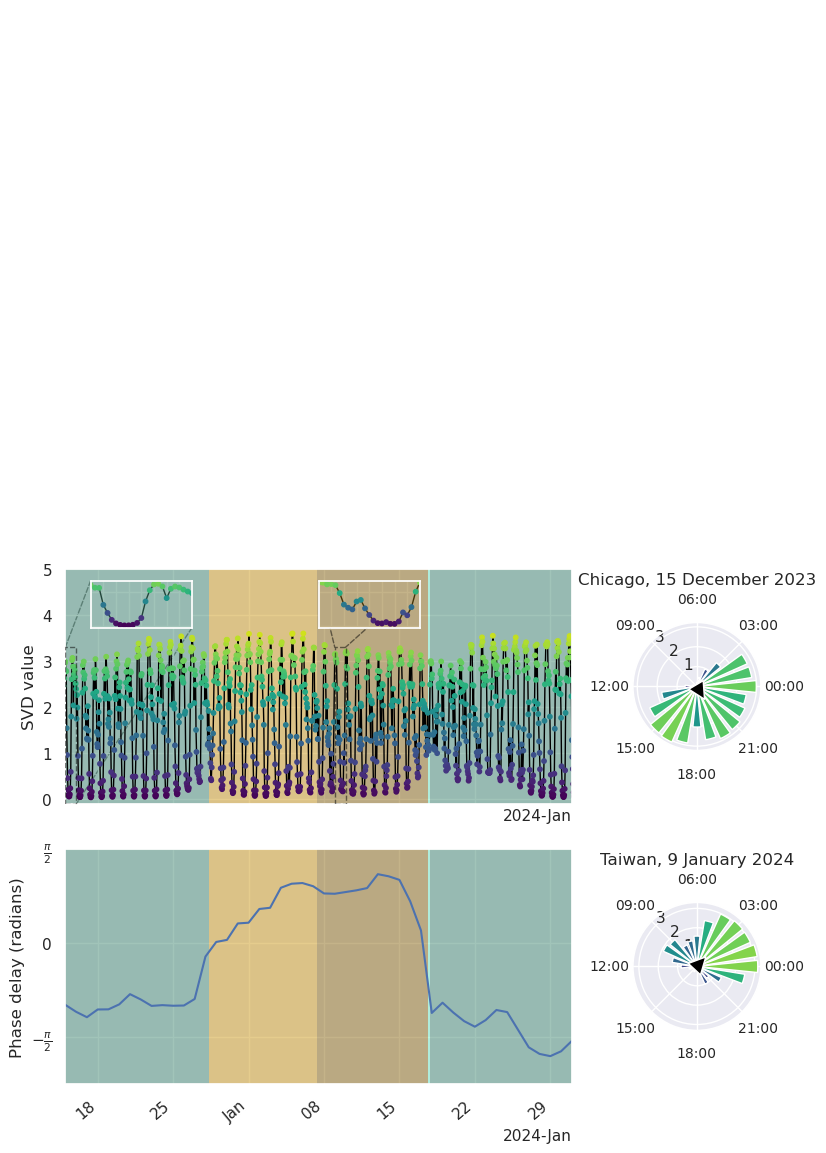

In [54]:
plt.close()

# A4 size
fig = plt.figure(figsize=(8.3, 11.7), layout="tight")

# 8 rows, 2 columns. First five rows remain empty for R plots
gs = GridSpec(8, 4, figure=fig)

# Empty
a = fig.add_subplot(gs[0:5, :])

a.axis('off')

# SVD values over time for trip to Taiwan
# a = fig.add_subplot(gs[3, :])
a = fig.add_subplot(gs[4:6, 0:3])

dates_svd = pd.to_datetime(svd_df_long['date'])
time_svd = dates_svd + pd.to_timedelta(svd_df_long['hour'], unit='hour')

min_dt = datetime(2023, 12, 15)
max_dt = datetime(2024, 1, 31)

colors = {
    'UTC-06:00': '#458B74', # aquamarine4
    'UTC+09:00': '#CD9B1D', # goldenrod3
    'UTC+08:00': '#8B6914', # goldenrod4
    'UTC-08:00': '#76EEC6', # aquamarine2
}

for i in range(5):
    trans = dat_transition.iloc[i]
    start, end = trans['session_timestamp'], trans['next_timestamp']
    rect = patches.Rectangle(
        (start, -1), end - start, 10, 
        linewidth=0, 
        facecolor=colors[trans['timezone']],
        alpha=0.5)
    a.add_patch(rect)

svd_vals = svd_mat.flatten()
a.plot(time_svd, svd_vals, c='black', linewidth=1, zorder=1)
a.scatter(time_svd, svd_vals, c=svd_vals, cmap='viridis', s=10, zorder=2)
a.set_xlim(min_dt, max_dt)
a.set_ylim(-0.1, 5)
a.set_ylabel("SVD value")

plt.setp(a.get_xticklabels(), visible=False)
# axes.get_xaxis().set_visible(False)

# Inset 1: SVD values over a single Chicago day
min_dt = datetime(2023, 12, 15)
max_dt = datetime(2023, 12, 16)

# a = fig.add_subplot(gs[4, :])
axout = a # Taiwan trip SVD axes
a = axout.inset_axes(
    (0.05, 0.75, 0.2, 0.2),
    xlim=(min_dt, max_dt),
    ylim=(-0.1, 3.3),
    xticklabels=[],
    yticklabels=[]
)

a.plot(time_svd, svd_vals, c='black', linewidth=1, zorder=1)
a.scatter(time_svd, svd_vals, c=svd_vals, cmap='viridis', s=10, zorder=2)

rect = patches.Rectangle(
    (min_dt, -1), max_dt - min_dt, 5, 
    linewidth=0, 
    facecolor='#458B74',
    alpha=0.5)
a.add_patch(rect)

# a.set_xlim(min_dt, max_dt)
# a.set_ylim(-0.1, 4)
# a.set_ylabel("SVD value")

# set_concise_dates(a)

_, lines = axout.indicate_inset_zoom(a, edgecolor='black', linestyle='--')

for l in lines:
    l.set_linestyle('--')
    l.set_zorder(-1)

# Inset 2: SVD values over a single Taiwan day
min_dt = datetime(2024, 1, 9)
max_dt = datetime(2024, 1, 10)

# a = fig.add_subplot(gs[4, :])
a = axout.inset_axes(
    (0.5, 0.75, 0.2, 0.2),
    xlim=(min_dt, max_dt),
    ylim=(-0.1, 3.3),
    xticklabels=[],
    yticklabels=[]
)

a.plot(time_svd, svd_vals, c='black', linewidth=1, zorder=1)
a.scatter(time_svd, svd_vals, c=svd_vals, cmap='viridis', s=10, zorder=2)

rect = patches.Rectangle(
    (min_dt, -1), max_dt - min_dt, 5, 
    linewidth=0, 
    facecolor='#8B6914',
    alpha=0.5)
a.add_patch(rect)

# a.set_xlim(min_dt, max_dt)
# a.set_ylim(-0.1, 4)
# a.set_ylabel("SVD value")

# set_concise_dates(a)

_, lines = axout.indicate_inset_zoom(a, edgecolor='black', linestyle='--')

for l in lines:
    l.set_linestyle('--')
    l.set_visible(not l.get_visible())

# Polar plot Chicago
a = fig.add_subplot(gs[4:6, 3], projection='polar')

i = 4
r = svd_mat[i, :]
draw_vector(mean_angles[i], mean_rs[i], a)
plot_polar(theta, r, a)

a.set_title("Chicago, 15 December 2023")

# Polar plot Taiwan
a = fig.add_subplot(gs[6:8, 3], projection='polar')

i = 29
r = svd_mat[i, :]
draw_vector(mean_angles[i], mean_rs[i], a)
plot_polar(theta, r, a)

a.set_title("Taiwan, 9 January 2024")

# Phase plot
a = fig.add_subplot(gs[6:8, 0:3], sharex=axout)

min_dt = datetime(2023, 12, 15)
max_dt = datetime(2024, 1, 31)

for i in range(5):
    trans = dat_transition.iloc[i]
    start, end = trans['session_timestamp'], trans['next_timestamp']
    rect = patches.Rectangle(
        (start, -np.pi), end - start, 2*np.pi, 
        linewidth=0, 
        facecolor=colors[trans['timezone']],
        alpha=0.5)
    a.add_patch(rect)

a.plot(dates_svd[0::24], mean_angles)
a.set_xlim(min_dt, max_dt)
a.set_ylabel("Phase delay (radians)")
a.set_yticks(np.linspace(-np.pi, np.pi/2, 4), 
             [r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$'])
a.set_ylim(-3*np.pi/4, np.pi/2) # Make the fluctuations a bit more obvious

set_concise_dates(a)

fig.savefig(join('images', 'alex', 'phase_analysis_bottom.pdf'))

plt.show()

# Cosine similarity

In [18]:
# null_vector = np.zeros((24,))
# null_vector[0] = 1

# Take second day as default
null_vector = svd_mat[1, :]
null_norm = np.linalg.norm(null_vector)

# Vector of dot products
dots = svd_mat @ null_vector

cos_sims = dots / (np.linalg.norm(svd_mat, axis=1) * null_norm)

In [39]:
# Calculated in R
dat_transition: pd.DataFrame = pq.read_table(join(dat_dir, 'BiAffect_Alex', 'dat_transition_alex.parquet')) \
    .to_pandas()

dat_transition

,session_timestamp,timezone,prev_timezone,next_timestamp
0,2023-12-10 19:24:46.733000+00:00,UTC-06:00,NaN,2023-12-28 07:52:58.859000+00:00
1,2023-12-28 07:52:58.859000+00:00,UTC+09:00,UTC-06:00,2024-01-07 07:52:02.464000+00:00
2,2024-01-07 07:52:02.464000+00:00,UTC+08:00,UTC+09:00,2024-01-17 15:37:06.711000+00:00
3,2024-01-17 15:37:06.711000+00:00,UTC-08:00,UTC+08:00,2024-01-17 20:14:23.581000+00:00
4,2024-01-17 20:14:23.581000+00:00,UTC-06:00,UTC-08:00,2024-03-10 09:52:27.852000+00:00
5,2024-03-10 09:52:27.852000+00:00,UTC-05:00,UTC-06:00,2024-03-31 07:26:41.711000+00:00
6,2024-03-31 07:26:41.711000+00:00,UTC+02:00,UTC-05:00,2024-04-29 17:30:44.996000+00:00
7,2024-04-29 17:30:44.996000+00:00,UTC-05:00,UTC+02:00,2024-06-01 12:49:39.349000+00:00
8,2024-06-01 12:49:39.349000+00:00,UTC+01:00,UTC-05:00,2024-06-08 13:57:33.281000+00:00
9,2024-06-08 13:57:33.281000+00:00,UTC-03:00,UTC+01:00,2024-06-08 14:00:40.813000+00:00


(19706.0, 19753.0)

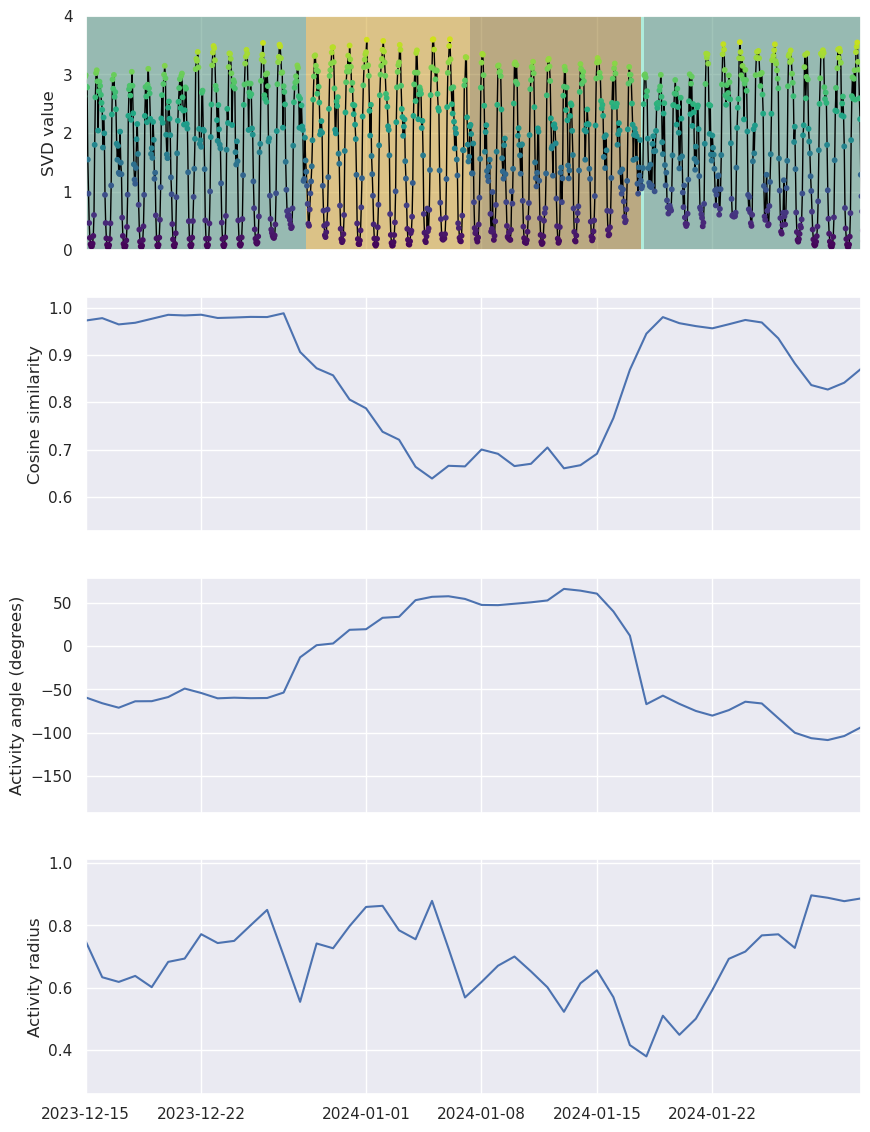

In [19]:
import matplotlib.patches as patches

plt.close()

min_dt = datetime(2023, 12, 15)
max_dt = datetime(2024, 1, 31)

dates_svd = pd.to_datetime(svd_df_long['date'])
time_svd = dates_svd + pd.to_timedelta(svd_df_long['hour'], unit='hour')

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(10, 14))

a = ax[0]

colors = {
    'UTC-06:00': '#458B74', # aquamarine4
    'UTC+09:00': '#CD9B1D', # goldenrod3
    'UTC+08:00': '#8B6914', # goldenrod4
    'UTC-08:00': '#76EEC6', # aquamarine2
}

for i in range(5):
    trans = dat_transition.iloc[i]
    start, end = trans['session_timestamp'], trans['next_timestamp']
    rect = patches.Rectangle(
        (start, -1), end - start, 5, 
        linewidth=0, 
        facecolor=colors[trans['timezone']],
        alpha=0.5)
    a.add_patch(rect)

svd_vals = svd_mat.flatten()
a.plot(time_svd, svd_vals, c='black', linewidth=1, zorder=1)
a.scatter(time_svd, svd_vals, c=svd_vals, cmap='viridis', s=10, zorder=2)
a.set_ylim(0, 4)
a.set_ylabel("SVD value")

# Cosine similarity
a = ax[1]

a.plot(dates_svd[0::24], cos_sims)
a.set_ylabel("Cosine similarity")

# Mean angles
a = ax[2]

a.plot(dates_svd[0::24], mean_angles / np.pi * 180)
a.set_ylabel("Activity angle (degrees)")

# Mean radii
a = ax[3]

a.plot(dates_svd[0::24], mean_rs)
a.set_ylabel("Activity radius")

plt.xlim(min_dt, max_dt)

# plt.plot(cos_sims)

# 3D plot

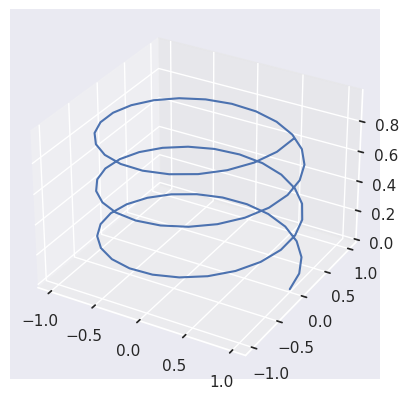

In [18]:
# Plot cylinder, for practice
plt.close()

ax = plt.figure().add_subplot(projection='3d')

# Three revolutions, 24 steps per revolution
theta = np.linspace(0, 6, 3*24) * np.pi

# Radius is 1, for now
x = np.cos(theta)
y = np.sin(theta)

# Z axis is arbitrary, i.e. not data-dependent
z = np.arange(0, 1, 1 / len(theta))

ax.plot(x, y, z)

plt.show()

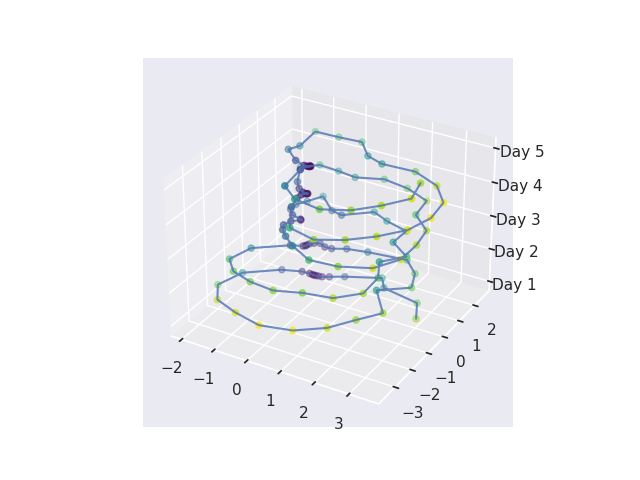

In [37]:
%matplotlib widget

plt.close()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Data defines radius
offset = 15
n_days = 5
r = svd_mat[offset:(offset+n_days), :].flatten()

# n_days revolutions, 24 steps per revolution
theta = np.linspace(0, n_days*2, n_days*24) * np.pi

# Radius is 1, for now
x = r * np.cos(theta)
y = r * np.sin(theta)

# Z axis is arbitrary, i.e. not data-dependent
z = np.linspace(0, 1, len(theta))

ax.plot(x, y, z, alpha=0.8)
ax.scatter(x, y, z, c=r, cmap='viridis')

ax.set_zticks(np.linspace(0, 1, n_days), [f"Day {i+1}" for i in range(n_days)])

plt.show()